# 10. Deep Learning for Time Series.
# 10.2. A Temperatue Forecasting Example
- Dataset: weather timeseries dataset recorded at the weather station at the Max Planck Institute for Biogeochemistry in Jena, Germany.
- In this dataset, 14 different quantities (such as temperature, pressure, humidity, wind direction, and so on) were recorded every 10 minutes over several years. The original data goes back to 2003, but the subset of the data we’ll download is limited to 2009–2016.
- **Research question**: Given the data cover the previous five days and sampled once per hour, can we predict the temperature in 24 hours?

## A. Import Data

In [1]:
!wget https://s3.amazonaws.com/keras-datasets/jena_climate_2009_2016.csv.zip
!unzip jena_climate_2009_2016.csv.zip

/bin/bash: /opt/conda/lib/libtinfo.so.6: no version information available (required by /bin/bash)
--2023-02-19 20:20:13--  https://s3.amazonaws.com/keras-datasets/jena_climate_2009_2016.csv.zip
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.217.175.104, 54.231.164.120, 52.216.179.5, ...
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.217.175.104|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13565642 (13M) [application/zip]
Saving to: ‘jena_climate_2009_2016.csv.zip’

jena_climate_2009_2 100%[===================>]  12.94M  18.8MB/s    in 0.7s    

2023-02-19 20:20:14 (18.8 MB/s) - ‘jena_climate_2009_2016.csv.zip’ saved [13565642/13565642]

/bin/bash: /opt/conda/lib/libtinfo.so.6: no version information available (required by /bin/bash)
Archive:  jena_climate_2009_2016.csv.zip
  inflating: jena_climate_2009_2016.csv  
  inflating: __MACOSX/._jena_climate_2009_2016.csv  


In [2]:
# import libraries
import os
import numpy as np
import matplotlib.pyplot as plt

# import tensorflow
from tensorflow import keras
from tensorflow.keras import layers

### Inspect Jena weather dataset

In [3]:
fname = os.path.join("jena_climate_2009_2016.csv")

with open(fname) as f:
    data = f.read()

lines = data.split("\n")
header = lines[0].split(",")
lines = lines[1:]
print(header)
print(len(lines))

['"Date Time"', '"p (mbar)"', '"T (degC)"', '"Tpot (K)"', '"Tdew (degC)"', '"rh (%)"', '"VPmax (mbar)"', '"VPact (mbar)"', '"VPdef (mbar)"', '"sh (g/kg)"', '"H2OC (mmol/mol)"', '"rho (g/m**3)"', '"wv (m/s)"', '"max. wv (m/s)"', '"wd (deg)"']
420451


**Note**: this means that we have 420,551 lines of data (timesteps) and 14 weather-related values.

### Parse data
- Convert all 420,551 timesteps into NumPy array: one array for the temperature (Celcius) and another for features (future temperatures).
- Discard the "Date Time" column. 

In [4]:
temperature = np.zeros((len(lines),))
raw_data = np.zeros((len(lines), len(header) - 1))

for i, line in enumerate(lines):
    values = [float(x) for x in line.split(",")[1:]]
    
    # store column 1 in the temperature array
    temperature[i] = values[1]
    
    # store all column in the raw data array
    raw_data[i, :] = values[:]

### Plot temperature timeseries

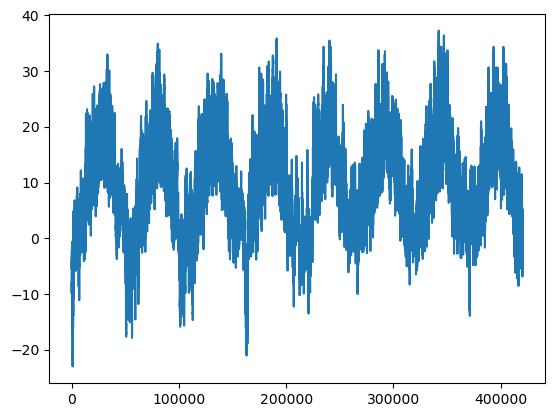

In [5]:
plt.plot(range(len(temperature)), temperature)

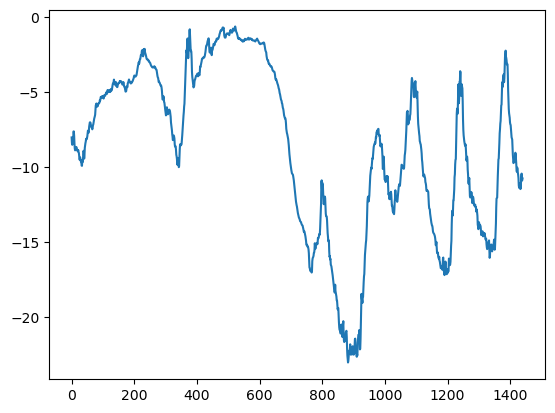

In [6]:
# plot the first 10 days
plt.plot(range(1440), temperature[:1440])

**Analysis**: We can see the periodicity in the last 4 days.
- Periodicity over multiple timescales is an important and very common property of timeseries data. Whether you’re looking at the weather, mall parking occupancy, traffic to a website, sales of a grocery store, or steps logged in a fitness tracker, you’ll see daily cycles and yearly cycles (human-generated data also tends to feature weekly cycles). When exploring your data, make sure to look for these patterns.

### Split the dataset into Train/Validation/Test set

In [7]:
num_train_samples = int(0.5 * len(raw_data))
num_val_samples = int(0.25 * len(raw_data))
num_test_samples = len(raw_data) - num_train_samples - num_val_samples

In [8]:
print("num_train_samples:", num_train_samples)
print("num_val_samples:", num_val_samples)
print("num_test_samples:", num_test_samples)

num_train_samples: 210225
num_val_samples: 105112
num_test_samples: 105114


## B. Data Processing
- We don't have to vecturize the data as it is numerical. However, since the data is in different sclae, we need to normalize it. WIthin the training data (210,225) timesteps as the training data, we compute the mean and std one the fracture of the data.
- Instead of parsing the data and store on local disk, we will store all data in Data object and parse it on the fly.
- About `timeseries_dataset_from_array()`: 
    - You provide an array of timeseries data and this function gives you windows extracted from original timeseries. For example, if you use data = [0 1 2 3 4 5 6] and sequence_length=3, then timeseries_dataset_from_array() will generate the following samples: [0 1 2], [1 2 3], [2 3 4], [3 4 5], [4 5 6].
    - You can also pass in a target argument to timeseries_dataset_from_array().

In [9]:
# examples

# generate array sorted from 0 to 9
int_sequence = np.arange(10)

dummy_dataset = keras.utils.timeseries_dataset_from_array(
    # get [0, 6] only
    data=int_sequence[:-3],
    
    # target every 3 timesteps
    targets=int_sequence[3:],
    
    # sequence of 3
    sequence_length=3,
    
    # the sequences will be batched in to size of 2
    batch_size=2,
)

In [10]:
for inputs, targets in dummy_dataset:
    for i in range(inputs.shape[0]):
        print([int(x) for x in inputs[i]], int(targets[i]))

[0, 1, 2] 3
[1, 2, 3] 4
[2, 3, 4] 5
[3, 4, 5] 6
[4, 5, 6] 7


### Normalize the data

In [11]:
mean = raw_data[:num_train_samples].mean(axis=0)
raw_data -= mean
std = raw_data[:num_train_samples].std(axis=0)
raw_data /= std

### Settings
- sampling_rate = 6—Observations will be sampled at one data point per hour: we will only keep one data point out of 6 (60 mins per hour and the record is every 10 mins).
- sequence_length = 120—Observations will go back 5 days (120 hours).
- delay = sampling_rate * (sequence_length + 24 - 1)—The target for a sequence will be the temperature 24 hours after the end of the sequence.
- Note: when we do this, we actually don't know the number of batches of the 3 datasets are until we finish sampling them. The number of batches is depending on the batch size.

### Instantiate datasets for training, validation, and testing

In [12]:
sampling_rate = 6
sequence_length = 120
delay = sampling_rate * (sequence_length + 24 - 1)
batch_size = 256 # number of samples per batch

train_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=0,
    end_index=num_train_samples)

val_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=num_train_samples,
    end_index=num_train_samples + num_val_samples)

test_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=num_train_samples + num_val_samples)

**Note**: each dataset yields a tuple (samples, targets), where samples is a batch of 256 samples, each contains 120 consecutive hours of input, and targets is the correct corresponding array of 256 target temperatures. Note that the samples are randomly shuffled so 2 consecutive sequences in batch (samples[0] and samples[1] aren't neccesarily close.

In [13]:
for samples, targets in train_dataset:
    print("samples shape:", samples.shape)
    print("targets shape:", targets.shape)
    break
print("train dataset size:",len(train_dataset))
print("validate dataset size:",len(val_dataset))
print("test dataset size",len(test_dataset))

samples shape: (256, 120, 14)
targets shape: (256,)
train dataset size: 819
validate dataset size: 408
test dataset size 405


## C. A common-sense, non ML baseline
- Such common-sense baselines can be useful when you are approaching a new problem for which there is no known solution yet.
- For our dataset, it can be safely assume to be continuous (temperature tomorrow are likely to be close to the temperatures today). **Thus, a common-sense approach is to always predict that the temperature 24 hours from now will be equal to the temperature right now.**

In [14]:
def evaluate_naive_method(dataset):
    total_abs_err = 0.
    samples_seen = 0
    for samples, targets in dataset:
        
        # the temperature feature is at column 1, so samples[:, -1, 1] is the last temperature measurement in the input sequence.
        # recall that we normalized our features, so to retrieve a temperature in degrees Celsius, we need to un-normalize it by multiplying it by the standard deviation and adding back the mean.
        preds = samples[:, -1, 1] * std[1] + mean[1]
        
        # target is sample 24 hours after so no need to do anything to get target
        total_abs_err += np.sum(np.abs(preds - targets))
        samples_seen += samples.shape[0]
    return total_abs_err / samples_seen

In [15]:
print(f"Validation MAE: {evaluate_naive_method(val_dataset):.2f}")
print(f"Test MAE: {evaluate_naive_method(test_dataset):.2f}")

Validation MAE: 2.44
Test MAE: 2.62


## D. Try a basic ML model
- We can build a simple densely connected model.

In [16]:
# build model
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.Flatten()(inputs)
x = layers.Dense(16, activation="relu")(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

In [17]:
# set up call back to save the best model only
callbacks = [
    keras.callbacks.ModelCheckpoint("jena_dense.keras",
    save_best_only=True)
]

In [18]:
# compile model
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
    
# train model
history = model.fit(train_dataset,
    epochs=10,
    validation_data=val_dataset,
    callbacks=callbacks)

Epoch 1/10
819/819 [==============================] - 53s 62ms/step - loss: 12.0461 - mae: 2.6863 - val_loss: 9.9842 - val_mae: 2.4834
Epoch 2/10
819/819 [==============================] - 46s 55ms/step - loss: 8.7419 - mae: 2.3225 - val_loss: 10.4844 - val_mae: 2.5505
Epoch 3/10
819/819 [==============================] - 45s 54ms/step - loss: 8.0184 - mae: 2.2267 - val_loss: 14.2158 - val_mae: 2.9941
Epoch 4/10
819/819 [==============================] - 51s 62ms/step - loss: 7.5920 - mae: 2.1680 - val_loss: 10.1861 - val_mae: 2.5126
Epoch 5/10
819/819 [==============================] - 51s 61ms/step - loss: 7.2938 - mae: 2.1263 - val_loss: 10.3513 - val_mae: 2.5414
Epoch 6/10
819/819 [==============================] - 45s 54ms/step - loss: 7.0887 - mae: 2.0975 - val_loss: 10.3171 - val_mae: 2.5241
Epoch 7/10
819/819 [==============================] - 45s 55ms/step - loss: 6.9303 - mae: 2.0763 - val_loss: 10.2951 - val_mae: 2.5266
Epoch 8/10
819/819 [==============================] - 4

In [19]:
# evaluate model
model = keras.models.load_model("jena_dense.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

405/405 [==============================] - 14s 35ms/step - loss: 11.0994 - mae: 2.6009
Test MAE: 2.60


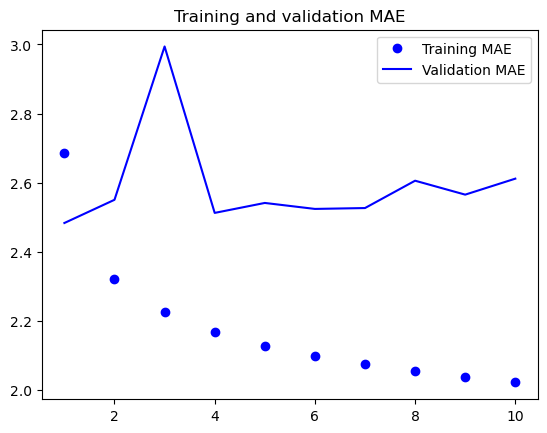

In [20]:
# plot result
loss = history.history["mae"]
val_loss = history.history["val_mae"]
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, "bo", label="Training MAE")
plt.plot(epochs, val_loss, "b", label="Validation MAE")
plt.title("Training and validation MAE")
plt.legend()
plt.show()

**Analysis**: Some of the validation losses are close to the no-learning baseline, but not reliably. This goes to show the merit of having this baseline in the first place: it turns out to be not easy to outperform. Your common sense contains a lot of valuable information to which a machine learning model doesn’t have access.

## E. Try 1D convolutional model

In [21]:
# build model
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.Conv1D(8, 24, activation="relu")(inputs)
x = layers.MaxPooling1D(2)(x)
x = layers.Conv1D(8, 12, activation="relu")(x)
x = layers.MaxPooling1D(2)(x)
x = layers.Conv1D(8, 6, activation="relu")(x)
x = layers.GlobalAveragePooling1D()(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

In [22]:
# set up call back to save the best model
callbacks = [
    keras.callbacks.ModelCheckpoint("jena_conv.keras",
    save_best_only=True)
]

In [23]:
# compile model
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])

# train and validate model
history = model.fit(train_dataset,
    epochs=10,
    validation_data=val_dataset,
    callbacks=callbacks)

Epoch 1/10
819/819 [==============================] - 52s 57ms/step - loss: 21.1337 - mae: 3.6141 - val_loss: 15.7971 - val_mae: 3.1438
Epoch 2/10
819/819 [==============================] - 53s 64ms/step - loss: 15.6070 - mae: 3.1344 - val_loss: 14.8436 - val_mae: 3.0334
Epoch 3/10
819/819 [==============================] - 53s 64ms/step - loss: 14.4323 - mae: 3.0135 - val_loss: 15.1908 - val_mae: 3.0860
Epoch 4/10
819/819 [==============================] - 46s 56ms/step - loss: 13.5604 - mae: 2.9218 - val_loss: 15.3033 - val_mae: 3.0884
Epoch 5/10
819/819 [==============================] - 52s 63ms/step - loss: 12.8162 - mae: 2.8398 - val_loss: 15.8725 - val_mae: 3.1370
Epoch 6/10
819/819 [==============================] - 47s 57ms/step - loss: 12.2375 - mae: 2.7747 - val_loss: 16.9757 - val_mae: 3.2365
Epoch 7/10
819/819 [==============================] - 54s 65ms/step - loss: 11.7072 - mae: 2.7151 - val_loss: 15.5867 - val_mae: 3.0857
Epoch 8/10
819/819 [============================

In [24]:
# test model
model = keras.models.load_model("jena_conv.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

405/405 [==============================] - 16s 36ms/step - loss: 16.8216 - mae: 3.2364
Test MAE: 3.24


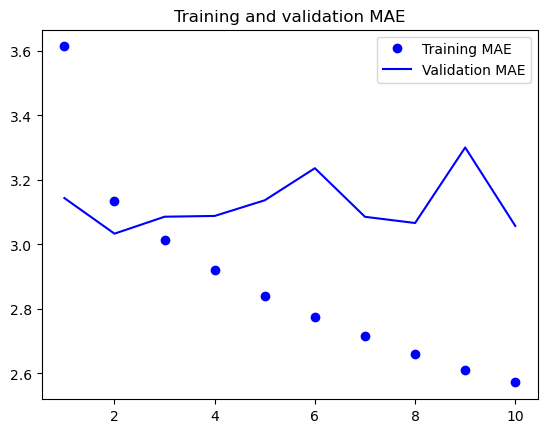

In [25]:
# plot result
loss = history.history["mae"]
val_loss = history.history["val_mae"]
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, "bo", label="Training MAE")
plt.plot(epochs, val_loss, "b", label="Validation MAE")
plt.title("Training and validation MAE")
plt.legend()
plt.show()

## F. First Recurrent Baseline

In [26]:
# build model
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.LSTM(16)(inputs)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

In [27]:
# set up call back to save the best model
callbacks = [
    keras.callbacks.ModelCheckpoint("jena_lstm.keras",
    save_best_only=True)
]

In [28]:
# compile model
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])

# train and validate model
history = model.fit(train_dataset,
    epochs=10,
    validation_data=val_dataset,
    callbacks=callbacks)

Epoch 1/10
819/819 [==============================] - 52s 61ms/step - loss: 38.5395 - mae: 4.5018 - val_loss: 12.0826 - val_mae: 2.6694
Epoch 2/10
819/819 [==============================] - 50s 61ms/step - loss: 10.7361 - mae: 2.5498 - val_loss: 9.8164 - val_mae: 2.4481
Epoch 3/10
819/819 [==============================] - 55s 67ms/step - loss: 9.7482 - mae: 2.4342 - val_loss: 9.8839 - val_mae: 2.4530
Epoch 4/10
819/819 [==============================] - 50s 60ms/step - loss: 9.4297 - mae: 2.3927 - val_loss: 9.6805 - val_mae: 2.4432
Epoch 5/10
819/819 [==============================] - 56s 67ms/step - loss: 9.0670 - mae: 2.3466 - val_loss: 9.4440 - val_mae: 2.4060
Epoch 6/10
819/819 [==============================] - 49s 59ms/step - loss: 8.8158 - mae: 2.3110 - val_loss: 9.6452 - val_mae: 2.4274
Epoch 7/10
819/819 [==============================] - 51s 62ms/step - loss: 8.6641 - mae: 2.2907 - val_loss: 9.5025 - val_mae: 2.4026
Epoch 8/10
819/819 [==============================] - 50s 6

In [29]:
# test model
model = keras.models.load_model("jena_lstm.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

405/405 [==============================] - 15s 36ms/step - loss: 10.7635 - mae: 2.5548
Test MAE: 2.55


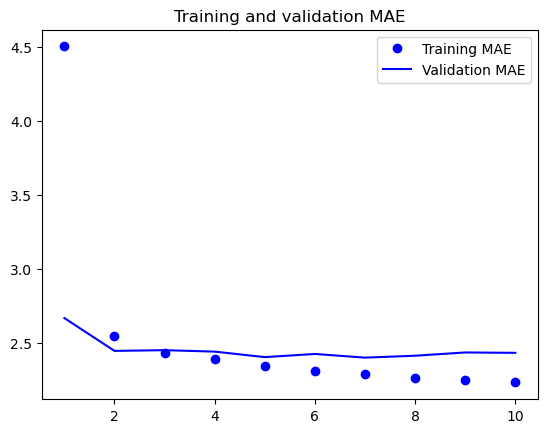

In [30]:
# plot result
loss = history.history["mae"]
val_loss = history.history["val_mae"]
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, "bo", label="Training MAE")
plt.plot(epochs, val_loss, "b", label="Validation MAE")
plt.title("Training and validation MAE")
plt.legend()
plt.show()

**Analysis**: Much better! We achieve a validation MAE as low as 2.36 degrees and a test MAE of 2.55 degrees. The LSTM-based model can finally beat the
common-sense baseline